In [1]:
args = {
    'model_name':'2019_04_11_DRIVE',
    'FP':'float16',
    'optimizer': 'Adam', #SGD, RMSprop, Adadelta, Adagrad, Adam, Adamax, Nadam
    'dataset':['101/training_data.csv', '102/training_data.csv', '103/training_data.csv', '104/training_data.csv', '105/training_data.csv', '106/training_data.csv', '107/training_data.csv'],
    'batch_size':1024, #512 with float32, 1024 with float16
    'split_point': 0.8, #80% Training , 20% Validation
    'rnd_seed': 1234,
    'epochs_number':250,
    'image_width': 320,
    'image_height': 90,
    'resume': False
}

In [2]:
# csv uznatılı dosyayı okuyabilmek için
import pandas as pd
# matris işlemleri için
import numpy as np
# opencv 
import cv2
# grafik kütüphanesi 
import matplotlib.pylab as plt
# histogram colors
from matplotlib import colors
# matplotlib grafiklerini jupyter notebook üzerinde göstermek için
%matplotlib inline
# rasgele sayı üretimi için
import random

In [3]:
# Eğitim için kaydettiğimiz seyir.csv dosaysını okuyoruz
for i, ds in enumerate(args['dataset']):
    try:
        tmp = pd.read_csv(ds)
    except:
        pass
    else:
        tmp['FileName'] = tmp['FileName'].apply(lambda x: ds.split('/')[0] + '/' + x)  
        if i == 0:
            df = tmp
        else:
            df = df.append(tmp, ignore_index=True)

In [4]:
# Seyir dosaysındaki sutun başlıkları
df.columns

Index([u'FileName', u'Speed', u'Angle'], dtype='object')

In [5]:
# Açı sutunu hakkında istatistiki bilgiler min max mean vs ...
df.Angle.describe()

count    33929.000000
mean        -0.023694
std          0.138602
min         -0.340000
25%         -0.102781
50%          0.000000
75%          0.000000
max          0.340000
Name: Angle, dtype: float64

In [6]:
# Toplam kayıt sayımız
len(df)

33929

In [7]:
# 20 den 40 kadar kayıtlar
df[0:10]

,FileName,Speed,Angle
0,101/00000.jpg,0.0,0.0
1,101/00001.jpg,0.0,0.0
2,101/00002.jpg,1.0,0.0
3,101/00003.jpg,1.0,0.0
4,101/00004.jpg,1.0,0.0
5,101/00005.jpg,1.0,0.0
6,101/00006.jpg,1.0,0.0
7,101/00007.jpg,1.0,0.0
8,101/00008.jpg,1.0,0.0
9,101/00009.jpg,1.0,0.0


In [8]:
df[-10:]

,FileName,Speed,Angle
33919,107/04541.jpg,1.0,0.000000
33920,107/04542.jpg,1.0,0.000000
33921,107/04543.jpg,1.0,-0.046131
33922,107/04544.jpg,1.0,-0.272732
33923,107/04545.jpg,1.0,-0.340000
33924,107/04546.jpg,1.0,-0.340000
33925,107/04547.jpg,1.0,-0.340000
33926,107/04548.jpg,1.0,-0.340000
33927,107/04549.jpg,1.0,-0.340000
33928,107/04550.jpg,1.0,0.000000


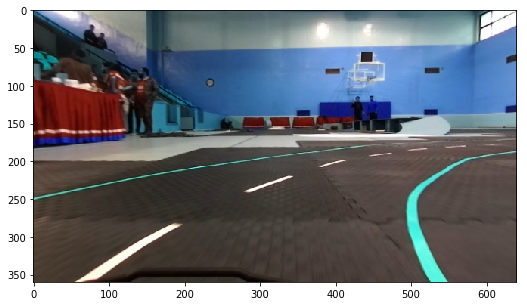

In [9]:
# Kayıt ettğimiz resmin birine bakıyoruz
image = cv2.imread(df.FileName[30])
plt.figure(figsize=(15,5))
plt.imshow(image)

<type 'numpy.uint8'>


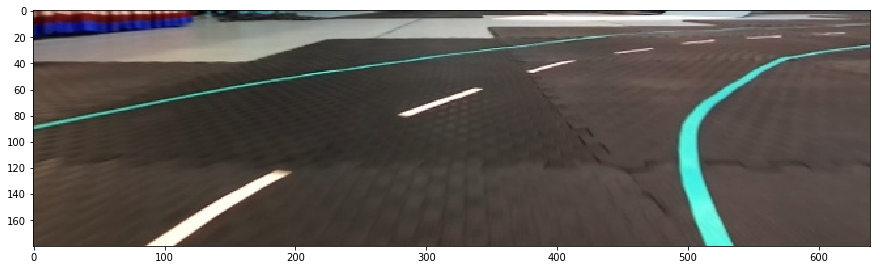

In [10]:
# Resmin her tarafını kullanmamıza gerek yok 
# çeşitli denemeler yaparak kırptığımız alanı görüyoruz
# Uygun gördüğümüz halini ağda kullanacağız
# Biz burda sadece sol görüntüyü  üstten 144 den 300 kadarlık kısmını alıyoruz 
tmp = image[160:340,:,:]
plt.figure(figsize=(15,5))
plt.imshow(tmp)
print(type(image[0,0,0]))

In [11]:
# Ağımızı eğitmek için  giriş verimiz resimler  çıkışımız da Açılar olacak
# bunları birer listeye aktarıyoruz
# Kamera ilk çekmeye başladığında düzgün çekemediği için başlangıçdan 30 kayıdı almıyoruz.
images = list(df.FileName[1:-1])
labels = list(df.Angle[1:-1])

In [12]:
len(labels)

33927

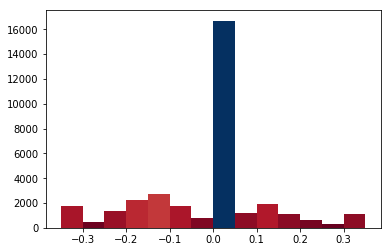

In [13]:
# Verimizdeki açıların dağılımı nasıl diye bir histogram yapıp bakıyoruz
# Dağılımın eşit şekilde olmaması eğitimin de düzgün olmamasına sebep olur
#plt.hist(labels, bins=14)
#plt.show()
N, bins, patches = plt.hist(labels,14, range=[-0.35,0.35], facecolor='blue', align='mid')
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.RdBu(norm(thisfrac))
    thispatch.set_facecolor(color)

#plt.axis([-0.4, 0.4, 0, 750])
plt.show()

In [14]:
tmp = []
start_value = -0.35
aralik = 0.05

for i in range(14):
    length=df.loc[(df['Angle'] > start_value) & (df['Angle'] <= start_value+aralik)]
    tmp.append(len(length))
    start_value = start_value + aralik
print(tmp[0:7]) # Eksi açı degerleri (Sag)
print(tmp[7:14]) # Pozitif açı degerleri (Sol)

[1738, 452, 1393, 2261, 2687, 1783, 802]
[16694, 1158, 1879, 1074, 631, 267, 1110]


In [15]:
# Veri setindeki açı dağılımını bir paröa düzeltmek için
# sayısı az olan açıdaki kayıtları listeye yeniden ekleyerek 
# daha düzgün hale getirmeye çalışıyoruz
def augment():
    nitem = len(images)
    for i in range(nitem):
        if labels[i] >= 0.05 and labels[i] <= 0.1:
            addValue=tmp[7]/tmp[8]
            for j in range(addValue-5):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] > 0.1 and labels[i] <= 0.15:
            addValue=tmp[7]/tmp[9]
            for j in range(addValue-3):
                images.append(images[i])
                labels.append(labels[i]) 

        if labels[i] > 0.15  and labels[i] <= 0.2:
            addValue=tmp[7]/tmp[10]
            for j in range(addValue-5):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] > 0.2  and labels[i] <= 0.25:
            addValue=tmp[7]/tmp[11]
            for j in range(addValue-10):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] > 0.25  and labels[i] <= 0.3:
            addValue=tmp[7]/tmp[12]
            for j in range(addValue-20):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] > 0.3  and labels[i] <= 0.35:
            addValue=tmp[7]/tmp[13]
            for j in range(addValue-5):
                images.append(images[i])
                labels.append(labels[i])


        #Negatif degerler

        if labels[i] < 0.0 and labels[i] > -0.05:
            addValue=tmp[7]/tmp[6]
            for j in range(addValue-5):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.05 and labels[i] > -0.1:
            addValue=tmp[7]/tmp[5]
            for j in range(addValue-3):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.1 and labels[i] > -0.15:
            addValue=tmp[7]/tmp[4]
            for j in range(addValue-3):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.15 and labels[i] > -0.2:
            addValue=tmp[7]/tmp[3]
            for j in range(addValue-3):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.2 and labels[i] > -0.25:
            addValue=tmp[7]/tmp[2]
            for j in range(addValue-4):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.25 and labels[i] > -0.3:
            addValue=tmp[7]/tmp[1]
            for j in range(addValue-10):
                images.append(images[i])
                labels.append(labels[i])

        if labels[i] <= -0.3 and labels[i] > -0.35:
            addValue=tmp[7]/tmp[0]
            for j in range(addValue-3):
                images.append(images[i])
                labels.append(labels[i])

In [16]:
augment()

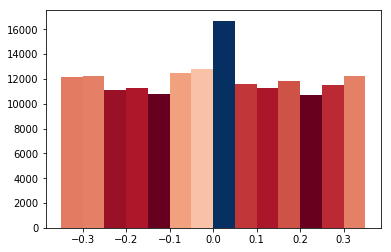

In [17]:
# İlk histgorama göre daga dengeli sayılabilecek bir dağılıma ulaştık
# En doğru çözüm değil ama pratik işe yarar bir alternatif
N, bins, patches = plt.hist(labels,14, range=[-0.35,0.35], facecolor='blue', align='mid')
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.RdBu(norm(thisfrac))
    thispatch.set_facecolor(color)

#plt.axis([-0.4, 0.4, 0, 750])
plt.show()

In [18]:
len(labels)

168658

In [19]:
# Veri setimiz ile ilgili ayarlamalar
# Veri seti küme büyüklüğü batch size
# Verisetinin ne kadarı eğitim ne kadarı test için kullanılacak
# Eğitim %80 , Test %20 
bsize = args['batch_size']
dlen = len(labels)
splitpoint = int(args['split_point']*dlen)
reindex = list(range(len(labels)))
# Eğtim verisini karıştıryoruz
random.seed(args['rnd_seed'])
random.shuffle(reindex)

In [20]:
# Resim üzerinde Rastgele parlaklık değişimi uygulayan bir fonksiyon
# Augmentation function (taken from github)
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV) 
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [21]:
#Resmi Kaydirma Sonradan Eklendi
def random_translate(image,range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image

In [22]:
def random_shadow(image,width,heigth):
    """
    Generates and adds random shadow
    """
    
    IMAGE_WIDTH=width
    IMAGE_HEIGHT=heigth
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    print(image.size)
    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.5, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    #plt.imshow(random_shadow(image))
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

In [23]:
# ismi verilen resmi okuyup 
# rastgele olarak %50 sine parlaklık değişimi uygulayan fonksiyonu uygulayıp
# resim matrisini dönem bir fonksiyon

def get_matrix(fname):
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    #img = img[160:340,:,:] # crop only
    if w != 640 or h != 360:
        img = cv2.resize(img, (640,360))
    img = cv2.resize(img[160:340,:,:], (args['image_width'],args['image_height'])) #crop then resize
    if random.randint(0,2) == 1:
        img = augment_brightness(img)   
    if random.randint(0,2) == 1:
        img = random_translate(img,100,0)  
    #if random.randint(0,2) == 1:
    #    img = random_shadow(img,320,90)
    return img

In [24]:
# Bütün veriyi hafızaya almamız mümkün değil
# Ek olarak bazen çeşitli değişimler - Augmentation - uygulamakda istiyebiliriz
# python generator ile gerektiğinde veri okunur düzenlenir ve eğitim veya test için 
# sisteme verilir
# alttaki fonksiyonlar bu işi yapar

# Generate data for training
def generate_data():
    i = 0
    while True:
        x = []
        y = []
        for j in range(i,i+bsize):  
            ix = reindex[j]
            img = get_matrix(images[ix])
            lbl = np.array([labels[ix]])
            flip = random.randint(0,1)
            if flip == 1:
                img = cv2.flip(img,1)
                lbl = lbl*-1.0
            x.append(img)
            y.append(lbl)
        x = np.array(x)
        y = np.array(y)
        #print("#------ Sending TRAINING batch ------#")
        yield (x,y)    
        i +=bsize
        if i+bsize > splitpoint:
            i = 0
            
# Generate data for validation                  
def generate_data_val():
    i = splitpoint
    while True:
        x = []
        y = []
        for j in range(i,i+bsize): 
            ix = reindex[j]
            x.append(get_matrix(images[ix]))
            y.append(np.array([labels[ix]]))
        x = np.array(x)
        y = np.array(y)
        #print("#------ Sending VALIDATION batch ------#")
        yield (x,y)    
        i +=bsize
        if i+bsize > dlen:
            i = splitpoint
            

In [25]:
# Keras için gerekenler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, Reshape
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam, Adamax, Nadam
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [26]:
import tensorflow as tf

In [27]:
#Destroy the current TF graph and create a new one
K.clear_session()
#import keras
#print(keras.__version__)
# make sure soft-placement is off

# allow_soft_placement: an op will be placed on CPU if not possible on GPU
# allow_growth: attempts to allocate only as much GPU memory based on runtime allocations 
# per_process_gpu_memory_fraction: set the fraction of the overall memory that each GPU should be allocated

tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.5
s = tf.Session(config=tf_config)
K.set_session(s)

# enable 16-bit training
K.set_floatx(args['FP'])
if args['FP'] == "float16":
    K.set_epsilon(1e-4)
K.floatx()

'float16'

In [28]:
# Model based on NVIDIA's End to End Learning for Self-Driving Cars model
#input shape, original paper uses 60*200, openzeka uses 80*320
shape=(args['image_height'],args['image_width'],3)
# Sıralı bir keras modeli tanılıyoruz
model = Sequential()
# Cropping
# gelen resmin istediğimiz ksımını kırpmak için bu katmanı yazıyoruz
# Cropping2D(cropping((top_crop, bottom_crop), (left_crop, right_crop)))
# aşağıdaki satırda 
# üstten 150 alttan 20 piksel 
# soldan 0 sağdan 640 piksel kırpılıyor
#model.add(Cropping2D(cropping=((150,20),(0,640)), input_shape=shape))
# Normalization
# 0 - 255 arası değerler -1 ila 1 arasına çekiliyor
model.add(Lambda(lambda x: (2*x / 255.0) - 1.0, input_shape=shape))
# lambda + cast
#model.add(Lambda(lambda x: tf.cast((2*x / 255.0) - 1.0 ,dtype=tf.float16)))
# cast to float16
#model.add(Lambda(lambda x: tf.cast(x,dtype=tf.float16)))
# Doesnt work, requires numpy array as input
#model.add(Lambda(lambda x: K.cast_to_floatx(x)))

# Evrişim katmanı (5, 5) lik 24 tane 2 şer piksel kayarak
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=l2(0.001)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=l2(0.001)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
#Flattendan once kullanilmayan baglantilari drop out yaptik(sonradan ekledik)
model.add(Dropout(0.5))
# Ağın çıkışı burda vectöre çevriliyor
model.add(Flatten())
# Yapay Sinir ağı kısmı
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
# Ağın çıkışı Açı 
model.add(Dense(1))
model.compile(loss='mse', optimizer=args['optimizer'], metrics=['mse', 'msle', 'mae', 'mape', 'cosine'])

In [29]:
# Tanımladığımız ağın yapsı
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 33, 64)         0         
__________

In [30]:
for layer in model.layers:
    print(layer.output)

Tensor("lambda_1/sub:0", shape=(?, 90, 320, 3), dtype=float16)
Tensor("conv2d_1/Relu:0", shape=(?, 43, 158, 24), dtype=float16)
Tensor("conv2d_2/Relu:0", shape=(?, 20, 77, 36), dtype=float16)
Tensor("conv2d_3/Relu:0", shape=(?, 8, 37, 48), dtype=float16)
Tensor("conv2d_4/Relu:0", shape=(?, 6, 35, 64), dtype=float16)
Tensor("conv2d_5/Relu:0", shape=(?, 4, 33, 64), dtype=float16)
Tensor("dropout_1/cond/Merge:0", shape=(?, 4, 33, 64), dtype=float16)
Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float16)
Tensor("dense_1/BiasAdd:0", shape=(?, 100), dtype=float16)
Tensor("dense_2/BiasAdd:0", shape=(?, 50), dtype=float16)
Tensor("dense_3/BiasAdd:0", shape=(?, 10), dtype=float16)
Tensor("dense_4/BiasAdd:0", shape=(?, 1), dtype=float16)


In [31]:
# Açı değerlerinide -0.3 ila 0.3 aralığından -1 ila 1 aralığına çekebilmek için 3 ile çarpıyoruz
print(type(labels[1]))
labels = 3*np.array(labels).astype(args['FP'])
print(type(labels[1]))

<type 'float'>
<type 'numpy.float16'>


In [32]:
model_name_full = args['model_name'] + '_' + args['FP'] + '_' + args['optimizer']

In [33]:
# Eğitim esnasında test hata değeri en düşük değeri kaydeden bir fonksiyon
model_checkpoint = ModelCheckpoint('models/' + model_name_full + '_weights_{epoch:03d}_{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, period=10)

In [ ]:
if args['resume']:
    model = load_model("")

In [34]:
# Eğitim fonksiyonu 
hs = model.fit_generator(generate_data(),steps_per_epoch=int(splitpoint/ bsize),
                    validation_data=generate_data_val(), 
                    validation_steps=(dlen-splitpoint)/bsize, epochs=args['epochs_number'], callbacks=[model_checkpoint])

Epoch 1/250
131/131 [==============================] - 337s 3s/step - loss: 0.3016 - mean_squared_error: 0.1410 - mean_squared_logarithmic_error: 0.0319 - mean_absolute_error: 0.2855 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.2069 - val_mean_squared_error: 0.0928 - val_mean_squared_logarithmic_error: 0.0192 - val_mean_absolute_error: 0.2266 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 2/250
131/131 [==============================] - 313s 2s/step - loss: 0.1753 - mean_squared_error: 0.0905 - mean_squared_logarithmic_error: 0.0204 - mean_absolute_error: 0.2269 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.1418 - val_mean_squared_error: 0.0776 - val_mean_squared_logarithmic_error: 0.0159 - val_mean_absolute_error: 0.2068 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 3/250
131/131 [==============================] - 313s 2s/step - loss: 0.1346 - mean_squared_error: 0.0

131/131 [==============================] - 311s 2s/step - loss: 0.0792 - mean_squared_error: 0.0606 - mean_squared_logarithmic_error: 0.0139 - mean_absolute_error: 0.1771 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0755 - val_mean_squared_error: 0.0571 - val_mean_squared_logarithmic_error: 0.0117 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 38/250
131/131 [==============================] - 312s 2s/step - loss: 0.0789 - mean_squared_error: 0.0605 - mean_squared_logarithmic_error: 0.0139 - mean_absolute_error: 0.1767 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0767 - val_mean_squared_error: 0.0581 - val_mean_squared_logarithmic_error: 0.0117 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 39/250
131/131 [==============================] - 312s 2s/step - loss: 0.0786 - mean_squared_error: 0.0602 - mean

131/131 [==============================] - 313s 2s/step - loss: 0.0752 - mean_squared_error: 0.0569 - mean_squared_logarithmic_error: 0.0133 - mean_absolute_error: 0.1710 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0732 - val_mean_squared_error: 0.0549 - val_mean_squared_logarithmic_error: 0.0115 - val_mean_absolute_error: 0.1690 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 74/250
131/131 [==============================] - 313s 2s/step - loss: 0.0757 - mean_squared_error: 0.0573 - mean_squared_logarithmic_error: 0.0132 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0714 - val_mean_squared_error: 0.0530 - val_mean_squared_logarithmic_error: 0.0111 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 75/250
131/131 [==============================] - 313s 2s/step - loss: 0.0751 - mean_squared_error: 0.0568 - mean

131/131 [==============================] - 312s 2s/step - loss: 0.0731 - mean_squared_error: 0.0547 - mean_squared_logarithmic_error: 0.0128 - mean_absolute_error: 0.1674 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0707 - val_mean_squared_error: 0.0523 - val_mean_squared_logarithmic_error: 0.0109 - val_mean_absolute_error: 0.1619 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 110/250
131/131 [==============================] - 312s 2s/step - loss: 0.0727 - mean_squared_error: 0.0543 - mean_squared_logarithmic_error: 0.0126 - mean_absolute_error: 0.1665 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0700 - val_mean_squared_error: 0.0515 - val_mean_squared_logarithmic_error: 0.0104 - val_mean_absolute_error: 0.1607 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 111/250
131/131 [==============================] - 313s 2s/step - loss: 0.0732 - mean_squared_error: 0.0547 - me

131/131 [==============================] - 312s 2s/step - loss: 0.0718 - mean_squared_error: 0.0534 - mean_squared_logarithmic_error: 0.0125 - mean_absolute_error: 0.1652 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0720 - val_mean_squared_error: 0.0535 - val_mean_squared_logarithmic_error: 0.0107 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 146/250
131/131 [==============================] - 311s 2s/step - loss: 0.0720 - mean_squared_error: 0.0534 - mean_squared_logarithmic_error: 0.0125 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0690 - val_mean_squared_error: 0.0505 - val_mean_squared_logarithmic_error: 0.0104 - val_mean_absolute_error: 0.1574 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 147/250
131/131 [==============================] - 312s 2s/step - loss: 0.0723 - mean_squared_error: 0.0536 - me

131/131 [==============================] - 312s 2s/step - loss: 0.0712 - mean_squared_error: 0.0525 - mean_squared_logarithmic_error: 0.0121 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0686 - val_mean_squared_error: 0.0500 - val_mean_squared_logarithmic_error: 0.0104 - val_mean_absolute_error: 0.1579 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 182/250
131/131 [==============================] - 312s 2s/step - loss: 0.0717 - mean_squared_error: 0.0530 - mean_squared_logarithmic_error: 0.0123 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0674 - val_mean_squared_error: 0.0487 - val_mean_squared_logarithmic_error: 0.0100 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 183/250
131/131 [==============================] - 313s 2s/step - loss: 0.0716 - mean_squared_error: 0.0529 - me

131/131 [==============================] - 312s 2s/step - loss: 0.0705 - mean_squared_error: 0.0516 - mean_squared_logarithmic_error: 0.0121 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0676 - val_mean_squared_error: 0.0487 - val_mean_squared_logarithmic_error: 0.0102 - val_mean_absolute_error: 0.1535 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 218/250
131/131 [==============================] - 312s 2s/step - loss: 0.0705 - mean_squared_error: 0.0517 - mean_squared_logarithmic_error: 0.0121 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: inf - cosine_proximity: nan - val_loss: 0.0676 - val_mean_squared_error: 0.0489 - val_mean_squared_logarithmic_error: 0.0102 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: inf - val_cosine_proximity: nan
Epoch 219/250
131/131 [==============================] - 314s 2s/step - loss: 0.0707 - mean_squared_error: 0.0519 - me

In [35]:
# Eğitim işleminin gidişatını grafik olarak görüyoruz
# Train and validation loss charts
print(hs.history.keys())

['loss', 'mean_squared_logarithmic_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity', 'val_mean_squared_logarithmic_error', 'mean_absolute_percentage_error', 'val_mean_squared_error', 'val_mean_absolute_error', 'cosine_proximity', 'mean_squared_error', 'val_loss', 'mean_absolute_error']


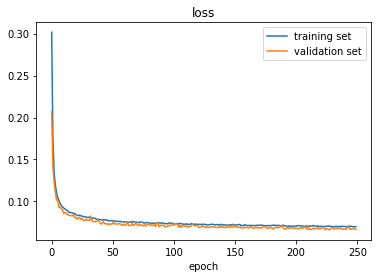

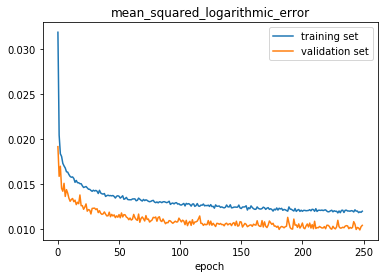

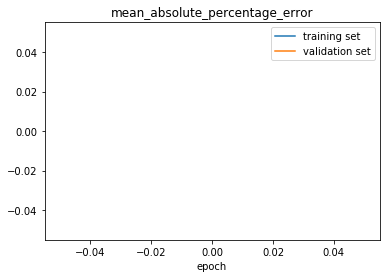

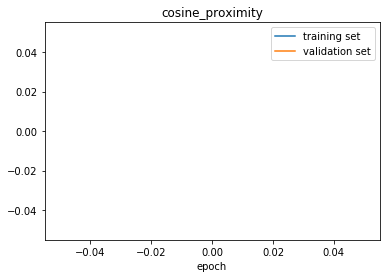

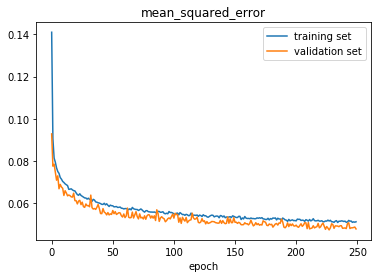

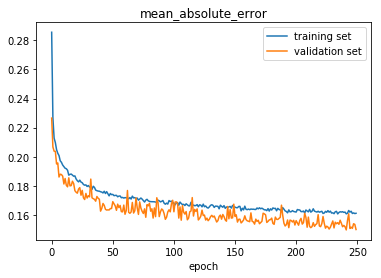

In [36]:
#for val in df.columns[1:]:
#    plt.title(val)
#    plt.plot(df.epoch,df[val])
#    plt.show()

for val in hs.history.keys():
    if "val_" not in val:
        plt.title(val)
        plt.plot(hs.history[val])
        plt.plot(hs.history['val_' + val])
        plt.xlabel('epoch')
        plt.legend(['training set', 'validation set'], loc='upper right')
        plt.savefig('models/' + model_name_full + '_' + val + '.png')
        plt.show()

In [37]:
try:
    plt.plot(hs.history['lr'])
    plt.title('Learning rate')
    plt.xlabel('epoch')
    plt.show()
except:
    pass

In [38]:
# Eğittiğimiz modeli kaydediyoruz
# Ağ yapsını json olarak
# Ağ parametre değerlerini h5 uzantılı olarak
import json 
# Save model weights and json.
model.save_weights('models/' + model_name_full + '_model.h5')
model_json  = model.to_json()
with open('models/' + model_name_full + '_model.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [39]:
# rastgele 10 resim seçip modelimiz hesapladığı sonuçla gerçeğine bakıyoruz 
# Eğer sonuçlar iyi ise kullanabiliriz
# Sonuççlar kötüyse eğitim aşamasına dönmemiz lazım
# Compare actual and predicted steering
for i in range(100):
    ix = random.randint(0,len(df)-1)
    out = model.predict(get_matrix(df.FileName[ix]).reshape(1,args['image_height'],args['image_width'],3))
    print(df.Angle[ix], ' - > ', out[0][0]/3)

(0.0, ' - > ', 0.3427734375)
(-0.258572280407, ' - > ', -0.19303385416666666)
(-0.120483756065, ' - > ', -0.1484375)
(0.0, ' - > ', -0.032206217447916664)
(-0.0921533256769, ' - > ', -0.12451171875)
(0.15944202244300001, ' - > ', 0.16748046875)
(-0.180676743388, ' - > ', -0.17333984375)
(-0.155888929963, ' - > ', -0.16959635416666666)
(0.0, ' - > ', 0.0023066202799479165)
(-0.0992385521531, ' - > ', -0.07478841145833333)
(-0.173591509461, ' - > ', -0.19401041666666666)
(-0.0779933556914, ' - > ', -0.06363932291666667)
(-0.15943153202500002, ' - > ', -0.15999348958333334)
(-0.11694113910199999, ' - > ', -0.17626953125)
(0.340000003576, ' - > ', 0.23828125)
(0.0, ' - > ', -0.035990397135416664)
(-0.340000003576, ' - > ', -0.24772135416666666)
(-0.10278116911599999, ' - > ', -0.155029296875)
(-0.0602907724679, ' - > ', -0.0811767578125)
(0.0, ' - > ', -0.08528645833333333)
(0.0567586384714, ' - > ', 0.085693359375)
(0.021353468298900002, ' - > ', 0.14705403645833334)
(-0.0284282118082, ' 